In [1]:
import numpy as np
import matplotlib.pyplot as plt

from real_gwb_likelihood_modified import GWBSpectrum

import pickle

from fakepta import fake_pta
from fakepta.fake_pta import Pulsar, copy_array, make_fake_array
from fakepta.correlated_noises import add_common_correlated_noise
from fakepta.fake_pta import plot_pta

import numpy as np
import emcee
from create_pta import make_pta

np.random.seed(5)

2025-10-20 12:18:24.653091: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/beatricetonello/opt/anaconda3/envs/thesisenv/lib/python3.11/site-packages/enterprise/signals/utils.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import Requirement, resource_filename


Optional mpi4py package is not installed.  MPI support is not available.


In [2]:
# EPTA DR2 total observation timespan
Tspan = 10.33 * 365.25 * 24 * 3600

fs = np.arange(1, 101) / Tspan
#print('Frequencies (Hz)', fs)

gwb_functions = GWBSpectrum()

/Users/beatricetonello/opt/anaconda3/envs/thesisenv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/beatricetonello/opt/anaconda3/envs/thesisenv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PowerTransformer from version 1.2.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Text(0, 0.5, 'h_c')

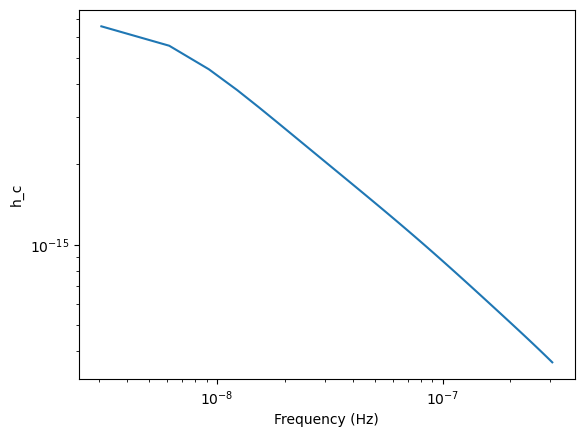

In [3]:
# 1st set of parameters: 
# A=-1.1 
# alpha=0.7
# beta=1. 
# M0=8.
# rho=2.4
# e0=0.49

mean, sigma, _ = gwb_functions.prediction6parameters_mean_sigma(freq=np.log10(fs), A=-1.1, alpha=0.7, beta=1., M0=8., rho=2.4, e0=0.49)

# this is the shape of the GWB spectrum that we will inject
plt.loglog(fs,mean)
plt.xlabel('Frequency (Hz)')
plt.ylabel('h_c')

In [4]:
# we transform the characteristic strain to rms timing deviation induced by the GWB (rho)
N = (12 * (np.pi**2) * (fs**3) * Tspan)**0.5
rho = mean / N

# then we compute the PSD S(f) 
S=(rho**2)*Tspan
S

array([1.26959085e-05, 1.13516962e-06, 2.23842604e-07, 6.60477154e-08,
       2.50677546e-08, 1.12821077e-08, 5.73360369e-09, 3.18889852e-09,
       1.90076616e-09, 1.19664442e-09, 7.87384782e-10, 5.37296608e-10,
       3.77990232e-10, 2.72889577e-10, 2.01446811e-10, 1.51609722e-10,
       1.16052591e-10, 9.01748131e-11, 7.10084247e-11, 5.65877064e-11,
       4.55842618e-11, 3.70806286e-11, 3.04325002e-11, 2.51805508e-11,
       2.09910201e-11, 1.76196037e-11, 1.48842356e-11, 1.26482009e-11,
       1.08074897e-11, 9.28224013e-12, 8.01078321e-12, 6.94475020e-12,
       6.04623242e-12, 5.28507106e-12, 4.63726807e-12, 4.08340701e-12,
       3.60789755e-12, 3.19803790e-12, 2.84340257e-12, 2.53543851e-12,
       2.26709188e-12, 2.03251641e-12, 1.82680325e-12, 1.64586859e-12,
       1.48627616e-12, 1.34511264e-12, 1.21994023e-12, 1.10866401e-12,
       1.00949846e-12, 9.20914858e-13, 8.41621414e-13, 7.70484896e-13,
       7.06533387e-13, 6.48929971e-13, 5.96942714e-13, 5.49939036e-13,
      

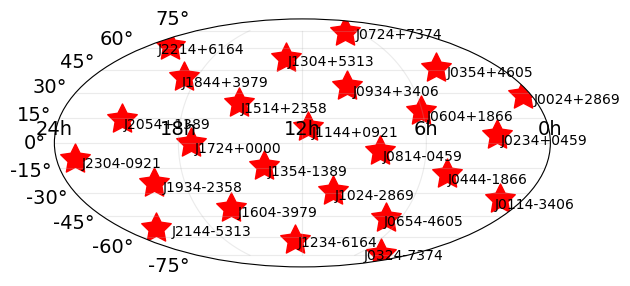

In [5]:
# Keep always the same pulsars
psrs = make_fake_array(npsrs=25, Tobs=10, ntoas=1000, isotropic=True, gaps=True, toaerr=1e-7, pdist=1., backends='NUPPI.1400', noisedict=None, custom_model={'RN':30, 'DM':100, 'Sv':None})
plot_pta(psrs)

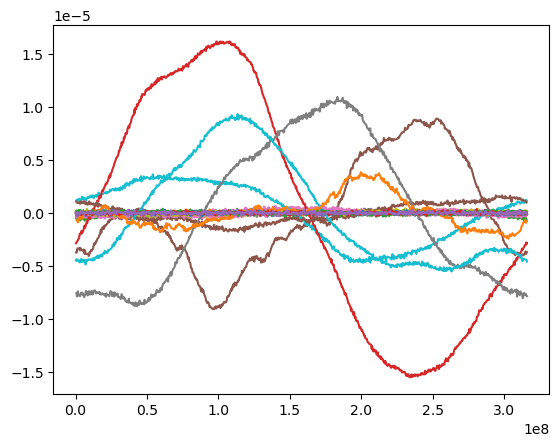

In [6]:
for psr in psrs:
    plt.plot(psr.toas, psr.residuals)
plt.show()

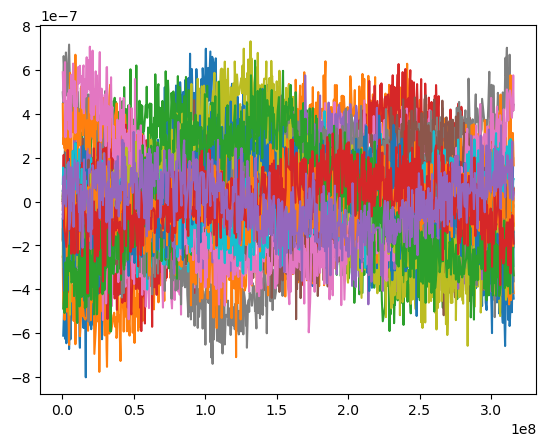

In [7]:
# make_ideal: flat residuals
# add_white_noise only
psd_NN = S
frequencies_NN = fs

for psr in psrs:
    psr.make_ideal()
    psr.add_white_noise()

# inject the signal
add_common_correlated_noise(psrs, orf='hd', spectrum='custom', name='gw', components=100, custom_psd=psd_NN, f_psd=frequencies_NN)

for psr in psrs:
    plt.plot(psr.toas, psr.residuals)
plt.show()

In [8]:
noisedict = {}
custom_models = {}
for psr in psrs:
    noisedict.update(psr.noisedict)
    custom_models[psr.name] = {'RN':None, 'DM':None, 'Sv':None}

Tspan = np.amax([psr.toas.max() for psr in psrs]) - np.amin([psr.toas.min() for psr in psrs])

pta = make_pta(psrs=psrs, crn_components=9, crn_spectrum='spectrum', noisedict=noisedict, custom_models=custom_models)

crn Tspan 3.168808781402895e-09


In [9]:
def LogPosterior(theta):
    
    return pta.get_lnlikelihood(theta) + pta.get_lnprior(theta)

In [10]:
ndim = 9  # number of parameters in the model
nwalkers = 18  # number of MCMC walkers
nsteps = int(60000)  # number of MCMC steps to take **for each walker**

theta_init=pta.params[0].sample()
starting_guesses = theta_init + 1e-2* np.random.randn(nwalkers, ndim)
print(starting_guesses.shape)

(18, 9)


In [11]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior)
sampler.run_mcmc(starting_guesses, nsteps, progress=True);

/Users/beatricetonello/opt/anaconda3/envs/thesisenv/lib/python3.11/site-packages/enterprise/signals/parameter.py:70: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [1:02:31<00:00, 15.99it/s]


In [12]:
print(sampler.get_chain().shape)

acc_frac = sampler.acceptance_fraction  # array, one per walker
print("Mean acceptance:", np.mean(acc_frac))

(60000, 18, 9)
Mean acceptance: 0.4050324074074074


In [13]:
# Get the autocorrelation lenght in each dimension

tau = sampler.get_autocorr_time()
print(tau)

[254.07905124 250.49926608 250.96477784 187.52297235  75.76123241
 243.95855627 273.28411028 215.31893532 331.34040521]


In [14]:
flat_samples = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)
print(flat_samples.shape)

(3204, 9)


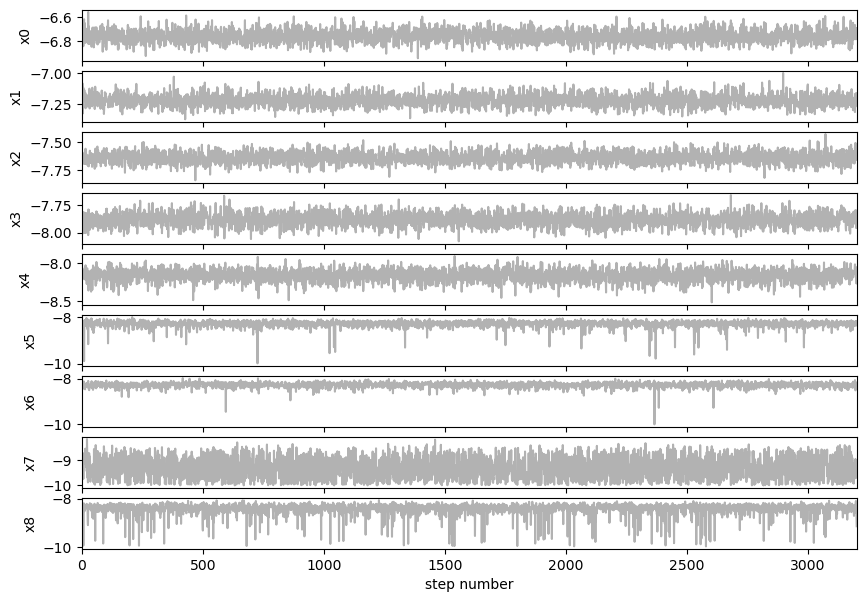

In [15]:
fig, axes = plt.subplots(9, figsize=(10, 7), sharex=True)
labels = ["x0","x1","x2","x3","x4","x5","x6","x7","x8"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(flat_samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(flat_samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Frequencies (Hz) [3.16880878e-09 6.33761756e-09 9.50642634e-09 1.26752351e-08
 1.58440439e-08 1.90128527e-08 2.21816615e-08 2.53504703e-08
 2.85192790e-08]


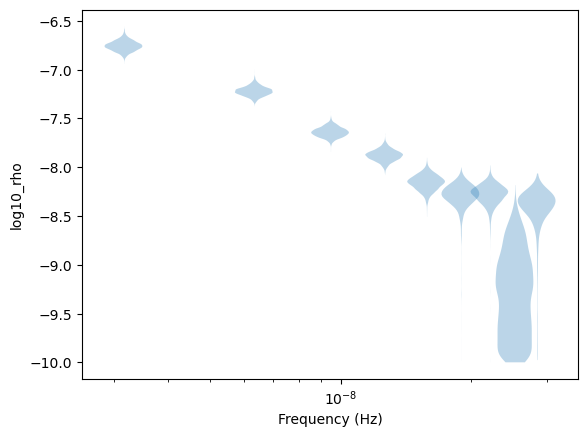

In [16]:
f = np.arange(1, 10) / Tspan
print('Frequencies (Hz)', f)

ax = plt.subplot(111)
ax.set_ylabel(r'log10_rho')
ax.violinplot(flat_samples, positions=f, widths=f*0.2, showmeans=False, showextrema=False)

plt.xlabel('Frequency (Hz)')
plt.xscale('log')
plt.show();

In [17]:
data = flat_samples

# transform log10(rho) to h_c

N = (12 * (np.pi**2) * (f**3) * Tspan)**0.5

for i in range (9):
    data[:,i] = (10**data[:,i])*N[i]
data

array([[5.09762267e-15, 5.77913183e-15, 5.03276481e-15, ...,
        2.91361113e-15, 1.59667067e-15, 5.08581105e-15],
       [7.15353326e-15, 5.42834641e-15, 3.83209126e-15, ...,
        3.53122242e-15, 4.25438922e-16, 3.02549894e-15],
       [6.74944527e-15, 8.07398308e-15, 3.97499333e-15, ...,
        4.72458890e-15, 7.25078076e-16, 4.74969441e-15],
       ...,
       [6.15357940e-15, 6.69820647e-15, 5.46646111e-15, ...,
        3.16096038e-15, 1.54314285e-16, 3.30521748e-15],
       [7.04114472e-15, 6.71235195e-15, 3.91763620e-15, ...,
        3.64087165e-15, 7.57007597e-16, 2.32535706e-15],
       [5.70127256e-15, 5.77061819e-15, 4.17520401e-15, ...,
        3.46904207e-15, 2.04592640e-16, 6.69645664e-16]], shape=(3204, 9))

In [18]:
# transform h_c to log10(h_c)

data = np.log10(data)
data

array([[-14.29263231, -14.2381374 , -14.29819336, ..., -14.53556841,
        -14.79678465, -14.29363978],
       [-14.1454794 , -14.26533245, -14.41656416, ..., -14.45207493,
        -15.37116278, -14.519203  ],
       [-14.17073192, -14.09291216, -14.4006636 , ..., -14.32563597,
        -15.13961523, -14.32333433],
       ...,
       [-14.21087219, -14.17404147, -14.26229374, ..., -14.50018095,
        -15.81159387, -14.48079996],
       [-14.15235673, -14.17312528, -14.4069759 , ..., -14.43879463,
        -15.12089976, -14.63351035],
       [-14.2440282 , -14.23877766, -14.3793223 , ..., -14.45979043,
        -15.68910999, -15.17415494]], shape=(3204, 9))

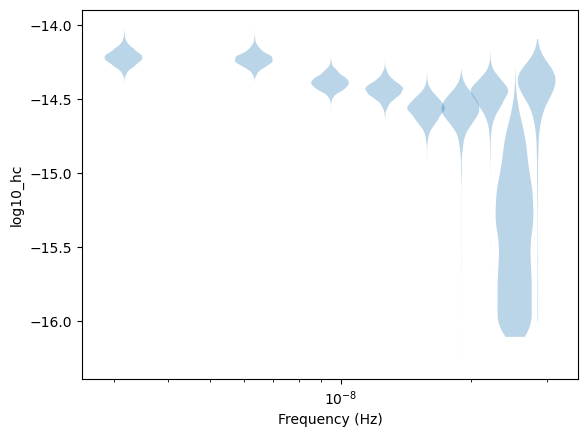

In [19]:
ax = plt.subplot(111)
ax.set_ylabel(r'log10_hc')
ax.violinplot(data, positions=f, widths=f*0.2, showmeans=False, showextrema=False)

plt.xlabel('Frequency (Hz)')
plt.xscale('log')
plt.show();

In [20]:
h_grid = np.linspace(1e-15, 1e-13, 10000)

In [22]:
# KDE on log10(h_c)
from scipy.stats import gaussian_kde

p_h_dt=[]
pdf_h_dt=[]

for i in range (0,9):
    pdf = gaussian_kde(data[:, i])
    pdf_h_dt.append(pdf)
    p_h_dt.append(pdf(np.log10(h_grid)))
    #plt.plot(h_grid,pdf(h_grid))

p_h_dt = np.column_stack(p_h_dt)

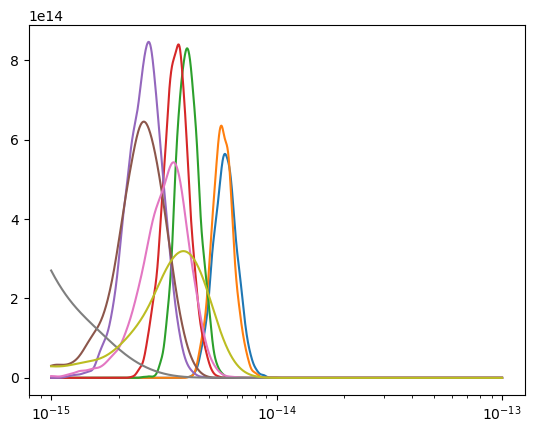

In [23]:
# transform from pdf(log10(h_c)) to pdf(h_c)

p_h=[]
for i in range(9):
    a=p_h_dt[:,i] / (h_grid * np.log(10))
    p_h.append(a)
    plt.plot(h_grid, a)

p_h = np.column_stack(p_h)
plt.xscale('log')

In [24]:
np.savetxt("2nd_test_p_h1e-7.txt", p_h)